In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

try:
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
except:
    print("NLTK downloads may fail in this environment")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
train_df = pd.read_csv("./Data/train_clean.csv")
valid_df = pd.read_csv("./Data/valid_clean.csv")
test_df  = pd.read_csv("./Data/test_clean.csv")

X_train = train_df.drop(columns=["ID", "Label"])
y_train = train_df["Label"]

X_valid = valid_df.drop(columns=["ID", "Label"])
y_valid = valid_df["Label"]

X_test  = test_df.drop(columns=["ID", "Label"])
y_test  = test_df["Label"]

text_col = "Statement"
cat_cols = ["Party Affiliation", "Speaker Job Title", "State Info"]
num_cols = ["char_count", "word_count", "avg_word_length", "true_ratio", "false_ratio"]

print("Data shapes:")
print(f"Training: {X_train.shape}")
print(f"Validation: {X_valid.shape}")
print(f"Test: {X_test.shape}")
print(f"\nLabel distribution in training:\n{y_train.value_counts()}")

Data shapes:
Training: (10240, 22)
Validation: (1284, 20)
Test: (1267, 20)

Label distribution in training:
Label
half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: count, dtype: int64


In [3]:
def basic_clean(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = text.lower()
        text = ' '.join(text.split())
    return text

def remove_stopwords(text):
    if isinstance(text, str):
        stop_words = set(stopwords.words('english'))
        words = text.split()
        words = [word for word in words if word not in stop_words]
        return ' '.join(words)
    return text

def stem_text(text):
    if isinstance(text, str):
        stemmer = PorterStemmer()
        words = text.split()
        words = [stemmer.stem(word) for word in words]
        return ' '.join(words)
    return text

def lemmatize_text(text):
    if isinstance(text, str):
        lemmatizer = WordNetLemmatizer()
        words = text.split()
        words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(words)
    return text

def preprocess_text_data(df, text_column, method='basic'):
    df_processed = df.copy()
    
    if method == 'basic':
        df_processed[text_column] = df_processed[text_column].apply(basic_clean)
    elif method == 'stopwords':
        df_processed[text_column] = df_processed[text_column].apply(basic_clean)
        df_processed[text_column] = df_processed[text_column].apply(remove_stopwords)
    elif method == 'stemming':
        df_processed[text_column] = df_processed[text_column].apply(basic_clean)
        df_processed[text_column] = df_processed[text_column].apply(remove_stopwords)
        df_processed[text_column] = df_processed[text_column].apply(stem_text)
    elif method == 'lemmatization':
        df_processed[text_column] = df_processed[text_column].apply(basic_clean)
        df_processed[text_column] = df_processed[text_column].apply(remove_stopwords)
        df_processed[text_column] = df_processed[text_column].apply(lemmatize_text)
    
    return df_processed

print("Text preprocessing functions defined successfully!")

Text preprocessing functions defined successfully!


In [4]:
preprocessing_methods = ['basic', 'stopwords', 'stemming', 'lemmatization']
vectorizers = {
    'tfidf_standard': TfidfVectorizer(max_features=5000, ngram_range=(1, 2)),
    'tfidf_large': TfidfVectorizer(max_features=10000, ngram_range=(1, 3)),
    'count_vectorizer': CountVectorizer(max_features=5000, ngram_range=(1, 2))
}

models = {
    'logistic_regression': LogisticRegression(
        max_iter=500, 
        class_weight="balanced", 
        C=0.1,
        penalty="l2",
        solver="lbfgs"
    ),
    'random_forest': RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42
    ),
    'gradient_boosting': GradientBoostingClassifier(
        n_estimators=100,
        random_state=42
    ),
    'svm_linear': SVC(
        kernel='linear',
        class_weight='balanced',
        random_state=42
    ),
    'naive_bayes': MultinomialNB()
}

cat_transformer = OneHotEncoder(handle_unknown="ignore")
num_transformer = StandardScaler()

print("Models and preprocessing configurations defined!")
print(f"Available models: {list(models.keys())}")
print(f"Available preprocessing methods: {preprocessing_methods}")
print(f"Available vectorizers: {list(vectorizers.keys())}")

Models and preprocessing configurations defined!
Available models: ['logistic_regression', 'random_forest', 'gradient_boosting', 'svm_linear', 'naive_bayes']
Available preprocessing methods: ['basic', 'stopwords', 'stemming', 'lemmatization']
Available vectorizers: ['tfidf_standard', 'tfidf_large', 'count_vectorizer']


In [5]:
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name, preprocess_method, vectorizer_name):
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    print(f"\n=== {model_name} - {preprocess_method} - {vectorizer_name} ===")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    cm = confusion_matrix(y_val, y_val_pred, labels=model.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=model.classes_, 
                yticklabels=model.classes_, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name} ({preprocess_method})")
    plt.show()
    
    return train_accuracy, val_accuracy, classification_report(y_val, y_val_pred, output_dict=True)


Testing: basic preprocessing + tfidf_standard

=== logistic_regression - basic - tfidf_standard ===
Training Accuracy: 0.4456
Validation Accuracy: 0.3621


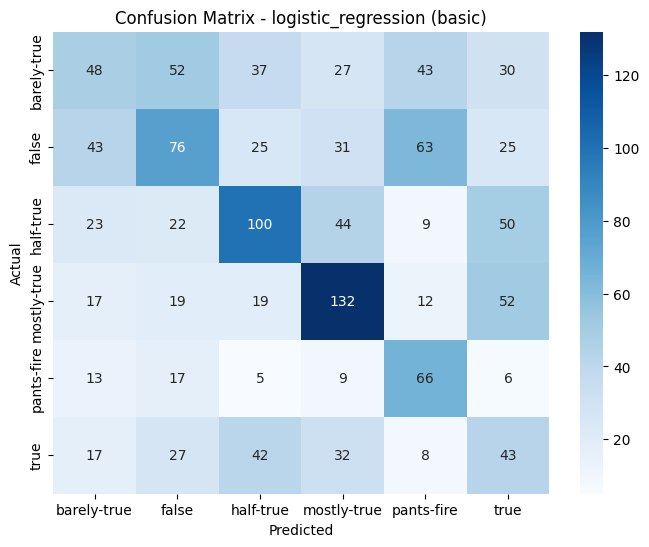


=== random_forest - basic - tfidf_standard ===
Training Accuracy: 0.9997
Validation Accuracy: 0.3808


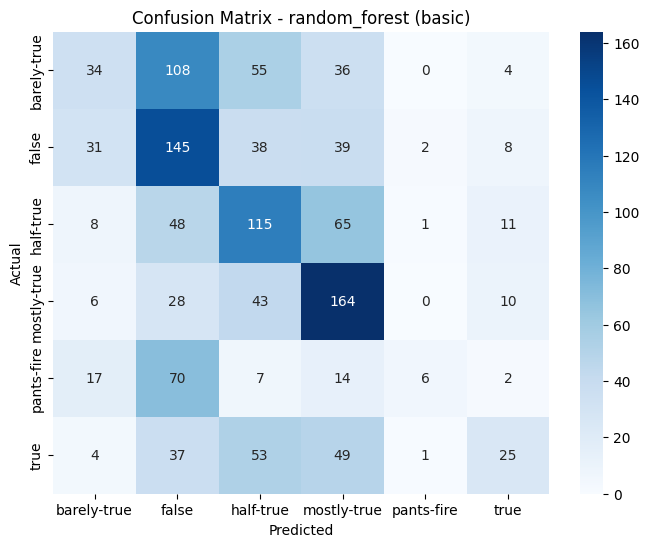


=== gradient_boosting - basic - tfidf_standard ===
Training Accuracy: 0.5527
Validation Accuracy: 0.3832


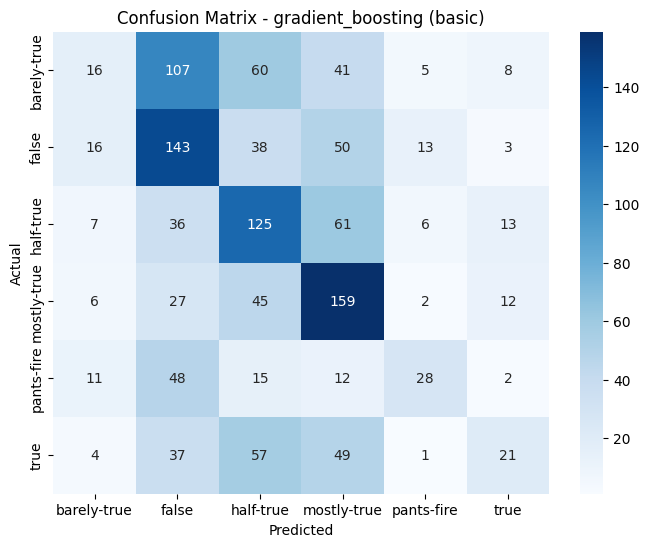


Testing: stopwords preprocessing + tfidf_standard

=== logistic_regression - stopwords - tfidf_standard ===
Training Accuracy: 0.4449
Validation Accuracy: 0.3575


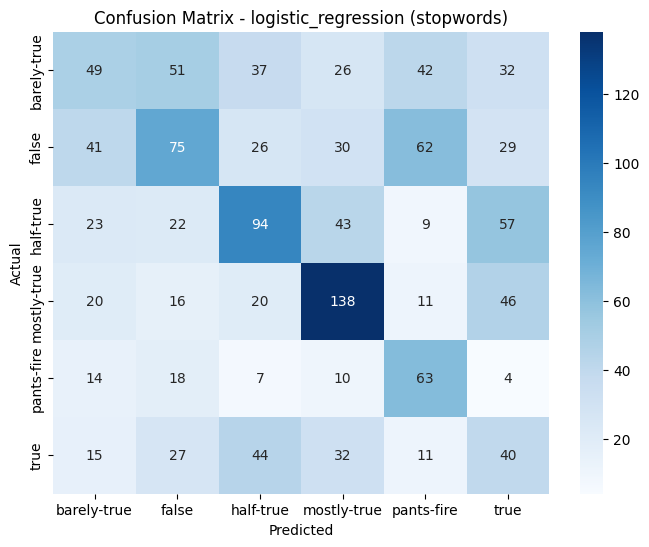


=== random_forest - stopwords - tfidf_standard ===
Training Accuracy: 0.9997
Validation Accuracy: 0.3692


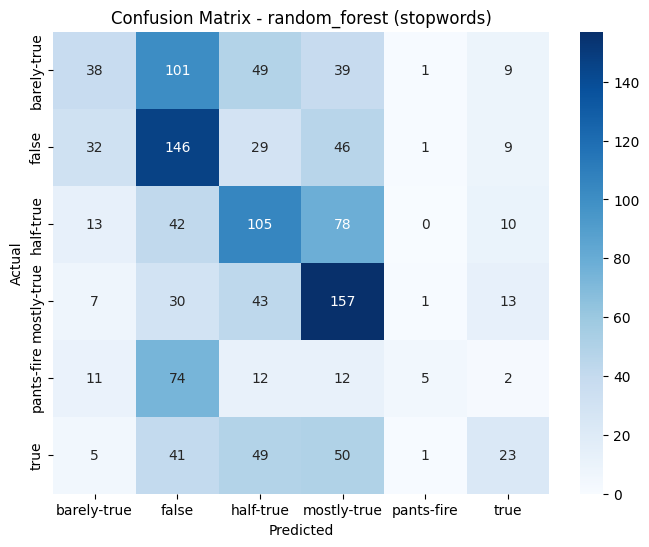


=== gradient_boosting - stopwords - tfidf_standard ===
Training Accuracy: 0.5380
Validation Accuracy: 0.3731


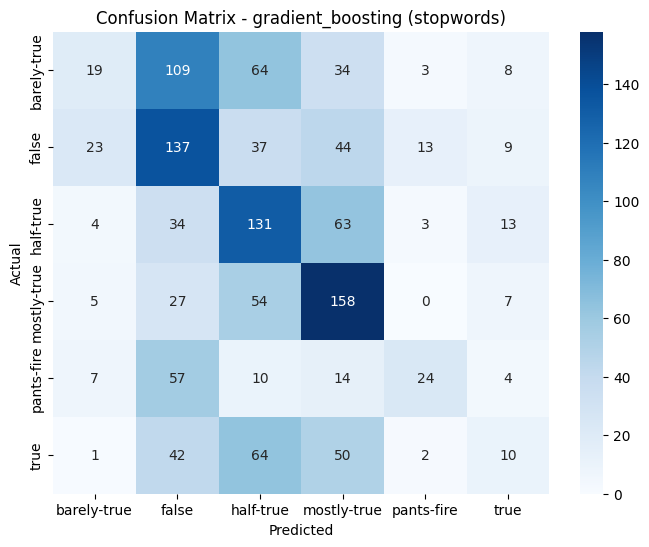


Testing: stemming preprocessing + tfidf_standard

=== logistic_regression - stemming - tfidf_standard ===
Training Accuracy: 0.4421
Validation Accuracy: 0.3606


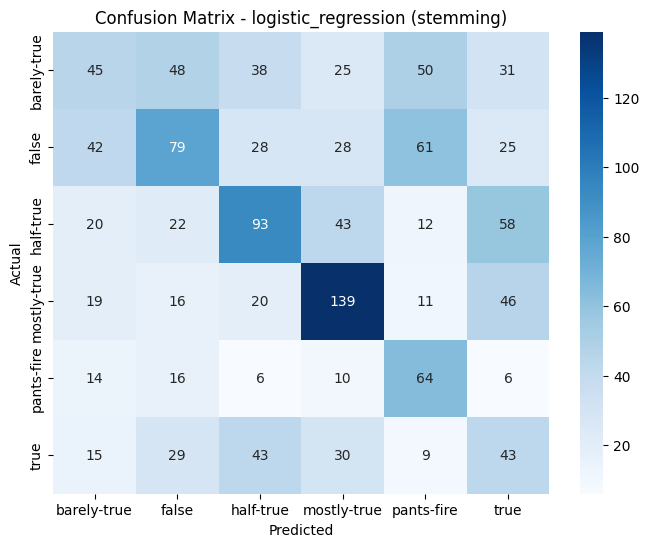


=== random_forest - stemming - tfidf_standard ===
Training Accuracy: 0.9997
Validation Accuracy: 0.3676


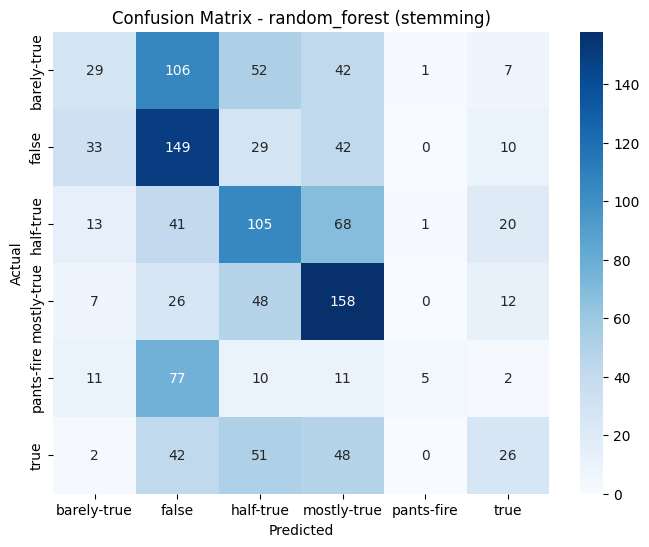


=== gradient_boosting - stemming - tfidf_standard ===
Training Accuracy: 0.5342
Validation Accuracy: 0.3808


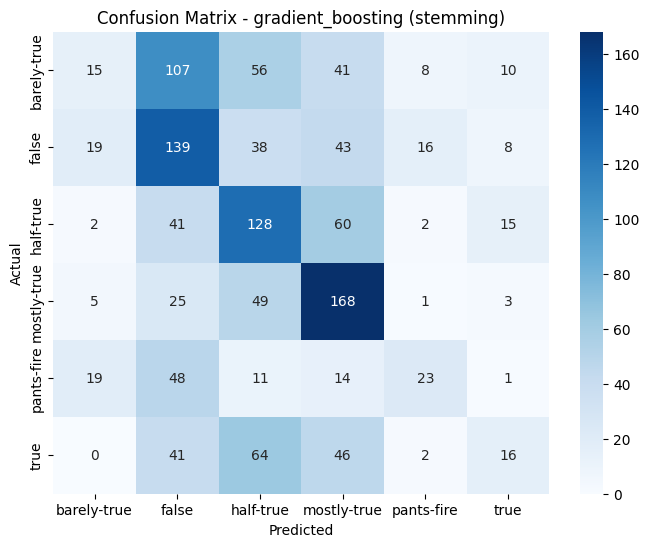


Testing: basic preprocessing + tfidf_large

=== logistic_regression - basic - tfidf_large ===
Training Accuracy: 0.4495
Validation Accuracy: 0.3606


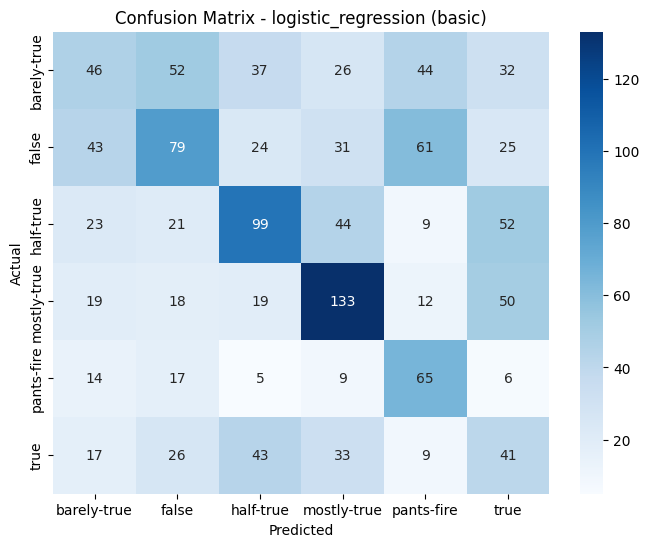


=== random_forest - basic - tfidf_large ===
Training Accuracy: 0.9997
Validation Accuracy: 0.3746


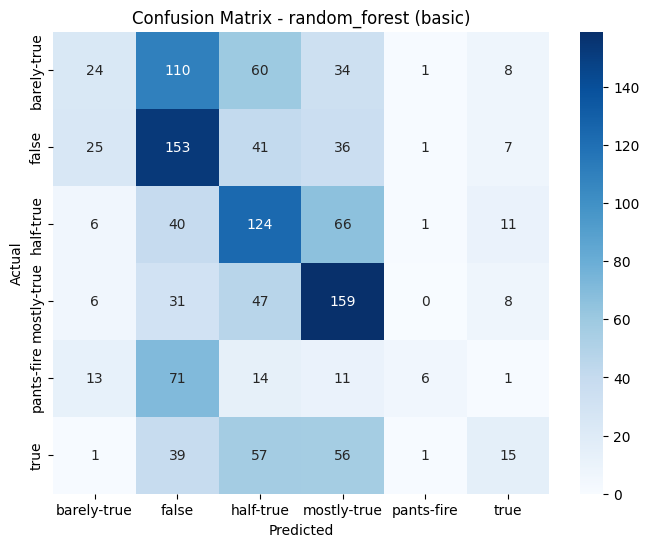


=== gradient_boosting - basic - tfidf_large ===
Training Accuracy: 0.5534
Validation Accuracy: 0.3816


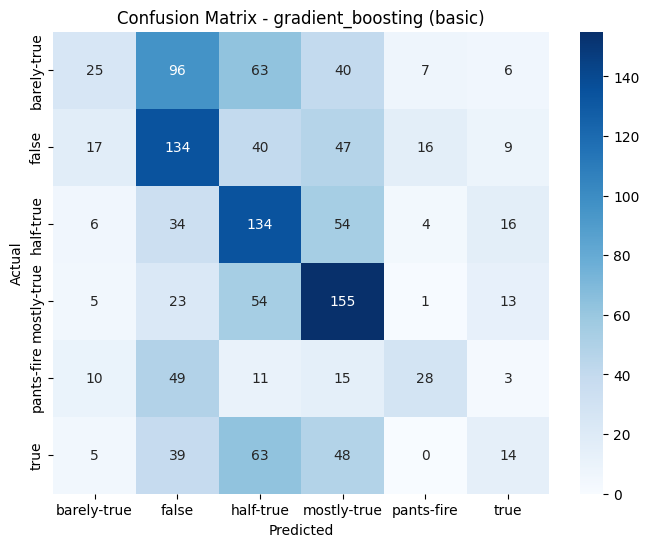


RESULTS SUMMARY (Sorted by Validation Accuracy):
              model preprocessing     vectorizer  train_accuracy  val_accuracy  f1_macro
  gradient_boosting         basic tfidf_standard        0.552734      0.383178  0.331287
  gradient_boosting         basic    tfidf_large        0.553418      0.381620  0.329451
  gradient_boosting      stemming tfidf_standard        0.534180      0.380841  0.317990
      random_forest         basic tfidf_standard        0.999707      0.380841  0.312072
      random_forest         basic    tfidf_large        0.999707      0.374611  0.292879
  gradient_boosting     stopwords tfidf_standard        0.537988      0.373053  0.312095
      random_forest     stopwords tfidf_standard        0.999707      0.369159  0.300805
      random_forest      stemming tfidf_standard        0.999707      0.367601  0.297849
logistic_regression         basic tfidf_standard        0.445605      0.362150  0.354723
logistic_regression      stemming tfidf_standard        0.44

In [6]:
results = []

test_combinations = [
    ('basic', 'tfidf_standard'),
    ('stopwords', 'tfidf_standard'), 
    ('stemming', 'tfidf_standard'),
    ('basic', 'tfidf_large')
]

for preprocess_method, vectorizer_name in test_combinations:
    print(f"\n{'='*60}")
    print(f"Testing: {preprocess_method} preprocessing + {vectorizer_name}")
    print(f"{'='*60}")
    
    X_train_processed = preprocess_text_data(X_train, text_col, preprocess_method)
    X_valid_processed = preprocess_text_data(X_valid, text_col, preprocess_method)
    
    text_vectorizer = vectorizers[vectorizer_name]
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("text", text_vectorizer, text_col),
            ("cat", cat_transformer, cat_cols),
            ("num", num_transformer, num_cols)
        ]
    )
    
    for model_name, model in list(models.items())[:3]: 
        try:
            pipeline = Pipeline([
                ("preprocess", preprocessor),
                ("clf", model)
            ])
            
            pipeline.fit(X_train_processed, y_train)
            
            train_accuracy, val_accuracy, report = evaluate_model(
                pipeline, X_train_processed, y_train, X_valid_processed, y_valid,
                model_name, preprocess_method, vectorizer_name
            )
            
            results.append({
                'model': model_name,
                'preprocessing': preprocess_method,
                'vectorizer': vectorizer_name,
                'train_accuracy': train_accuracy,
                'val_accuracy': val_accuracy,
                'f1_macro': report['macro avg']['f1-score']
            })
            
        except Exception as e:
            print(f"Error with {model_name}: {e}")
            continue

results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("RESULTS SUMMARY (Sorted by Validation Accuracy):")
print("="*80)
print(results_df.sort_values('val_accuracy', ascending=False).to_string(index=False))

In [7]:
if not results_df.empty:
    best_result = results_df.loc[results_df['val_accuracy'].idxmax()]
    print(f"\n{'='*60}")
    print("BEST MODEL FOUND:")
    print(f"{'='*60}")
    print(f"Model: {best_result['model']}")
    print(f"Preprocessing: {best_result['preprocessing']}")
    print(f"Vectorizer: {best_result['vectorizer']}")
    print(f"Training Accuracy: {best_result['train_accuracy']:.4f}")
    print(f"Validation Accuracy: {best_result['val_accuracy']:.4f}")
    print(f"F1 Macro Score: {best_result['f1_macro']:.4f}")
    
    best_preprocess = best_result['preprocessing']
    best_vectorizer = best_result['vectorizer']
    best_model_name = best_result['model']
    
    print(f"\nNOTE: Test set is preserved for final evaluation only!")
    print(f"Best parameters saved for potential test evaluation.")
else:
    print("No results to analyze!")


BEST MODEL FOUND:
Model: gradient_boosting
Preprocessing: basic
Vectorizer: tfidf_standard
Training Accuracy: 0.5527
Validation Accuracy: 0.3832
F1 Macro Score: 0.3313

NOTE: Test set is preserved for final evaluation only!
Best parameters saved for potential test evaluation.


In [8]:
def test_specific_model(model_name, preprocess_method, vectorizer_name):
    print(f"\nTesting {model_name} with {preprocess_method} preprocessing and {vectorizer_name}...")
    
    X_train_proc = preprocess_text_data(X_train, text_col, preprocess_method)
    X_valid_proc = preprocess_text_data(X_valid, text_col, preprocess_method)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("text", vectorizers[vectorizer_name], text_col),
            ("cat", cat_transformer, cat_cols),
            ("num", num_transformer, num_cols)
        ]
    )
    
    pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("clf", models[model_name])
    ])
    
    pipeline.fit(X_train_proc, y_train)
    y_train_pred = pipeline.predict(X_train_proc)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    y_val_pred = pipeline.predict(X_valid_proc)
    val_accuracy = accuracy_score(y_valid, y_val_pred)
    
    print(f"\nResults for {model_name}:")
    print(f"  Preprocessing: {preprocess_method}")
    print(f"  Vectorizer: {vectorizer_name}")
    print(f"  Training Accuracy: {train_accuracy:.4f}")
    print(f"  Validation Accuracy: {val_accuracy:.4f}")
    
    print(f"\nValidation Classification Report:")
    print(classification_report(y_valid, y_val_pred))
    
    return pipeline, train_accuracy, val_accuracy

trained_model, train_acc, val_acc = test_specific_model('logistic_regression', 'lemmatization', 'tfidf_large')
trained_model, train_acc, val_acc = test_specific_model('random_forest', 'basic', 'tfidf_standard')


Testing logistic_regression with lemmatization preprocessing and tfidf_large...

Results for logistic_regression:
  Preprocessing: lemmatization
  Vectorizer: tfidf_large
  Training Accuracy: 0.4445
  Validation Accuracy: 0.3520

Validation Classification Report:
              precision    recall  f1-score   support

 barely-true       0.29      0.19      0.23       237
       false       0.36      0.29      0.32       263
   half-true       0.41      0.37      0.39       248
 mostly-true       0.49      0.54      0.52       251
  pants-fire       0.31      0.53      0.39       116
        true       0.19      0.24      0.21       169

    accuracy                           0.35      1284
   macro avg       0.34      0.36      0.34      1284
weighted avg       0.35      0.35      0.35      1284


Testing random_forest with basic preprocessing and tfidf_standard...

Results for random_forest:
  Preprocessing: basic
  Vectorizer: tfidf_standard
  Training Accuracy: 0.9997
  Validation A

In [9]:
if not results_df.empty:
    print("\n" + "="*60)
    print("FINAL MODEL TRAINING (Combined Train+Validation)")
    print("="*60)
    
    best_preprocess = best_result['preprocessing']
    best_vectorizer = best_result['vectorizer']
    best_model_name = best_result['model']
    
    X_combined = pd.concat([X_train, X_valid])
    y_combined = pd.concat([y_train, y_valid])
    
    X_combined_processed = preprocess_text_data(X_combined, text_col, best_preprocess)
    
    final_preprocessor = ColumnTransformer(
        transformers=[
            ("text", vectorizers[best_vectorizer], text_col),
            ("cat", cat_transformer, cat_cols),
            ("num", num_transformer, num_cols)
        ]
    )
    
    final_pipeline = Pipeline([
        ("preprocess", final_preprocessor),
        ("clf", models[best_model_name])
    ])
    
    final_pipeline.fit(X_combined_processed, y_combined)
    
    y_combined_pred = final_pipeline.predict(X_combined_processed)
    combined_train_accuracy = accuracy_score(y_combined, y_combined_pred)
    
    print(f"Final model trained successfully!")
    print(f"Model: {best_model_name}")
    print(f"Preprocessing: {best_preprocess}")
    print(f"Vectorizer: {best_vectorizer}")
    print(f"Combined Training Accuracy: {combined_train_accuracy:.4f}")
    
    print("\nIMPORTANT: Test set is preserved for final evaluation!")
    print("To evaluate on test set, use the final_pipeline object.")
else:
    print("No results available for final model training!")


FINAL MODEL TRAINING (Combined Train+Validation)
Final model trained successfully!
Model: gradient_boosting
Preprocessing: basic
Vectorizer: tfidf_standard
Combined Training Accuracy: 0.5403

IMPORTANT: Test set is preserved for final evaluation!
To evaluate on test set, use the final_pipeline object.


In [10]:
print("TEST EVALUATION TEMPLATE")
print("="*50)
print("""
# To evaluate on test set (run only when ready for final evaluation):

# 1. Preprocess test data
X_test_processed = preprocess_text_data(X_test, text_col, best_preprocess)

# 2. Make predictions
y_test_pred = final_pipeline.predict(X_test_processed)

# 3. Evaluate
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# 4. Plot confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred, labels=final_pipeline.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", xticklabels=final_pipeline.classes_, 
            yticklabels=final_pipeline.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Final Test Confusion Matrix - {best_model_name}")
plt.show()
""")

TEST EVALUATION TEMPLATE

# To evaluate on test set (run only when ready for final evaluation):

# 1. Preprocess test data
X_test_processed = preprocess_text_data(X_test, text_col, best_preprocess)

# 2. Make predictions
y_test_pred = final_pipeline.predict(X_test_processed)

# 3. Evaluate
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print("
Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# 4. Plot confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred, labels=final_pipeline.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", xticklabels=final_pipeline.classes_, 
            yticklabels=final_pipeline.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Final Test Confusion Matrix - {best_model_name}")
plt.show()

